In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import errno
import torch.utils.data
from model import Net, Resize
#from sklearn.linear_model import LogisticRegression
#from sklearn import svm
#from sklearn import metrics
#from process_data import preprocess_data
from train_stonet import train_stonet
from model import DNN
import argparse
import time
import math
from tools import *
from sklearn.preprocessing import MinMaxScaler

import dcor

import matplotlib.pyplot as plt

from time import process_time

from pytorch_lightning import seed_everything
seed_everything(42, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

[rank: 0] Global seed set to 42


In [2]:
parser = argparse.ArgumentParser(description="Running StoNet")
parser.add_argument('--seed', default=1, type = int, help = 'set seed')
parser.add_argument('--data_path', default="./data/", type=str, help='folder name for loading data')
parser.add_argument('--base_path', default='./result/', type = str, help = 'base path for saving result')
parser.add_argument('--model_path', default='./', type=str, help='folder name for saving model')
parser.add_argument('--data_index', default=0, type=int)
parser.add_argument('--data_name', default='waveform', type=str, help='the name of the dataset')
parser.add_argument('--device', default='cpu', type=str, help='the device used to run the experiment')
parser.add_argument('--model1', default=1, type = int, help = 'model1')
parser.add_argument('--model2', default=1, type = int, help = 'model2')
parser.add_argument('--n', default=1000, type = int, help = 'n')
parser.add_argument('--r', default=10, type = int, help = 'r')


# Training Setting
parser.add_argument('--num_epochs', default=60, type=int, help='total number of training epochs')
parser.add_argument('--momentum', default=0.9, type=float, help='momentum in SGD')
parser.add_argument('--weight_decay', default=0, type=float, help='weight decay in SGD')
parser.add_argument('--batch_size', default=64, type=int, help='batch size for training')
parser.add_argument('--MH_step', default=25, type=int, help='SGLD step for imputation')
parser.add_argument('--sigma_list', default=[1e-1, 1e-2], nargs='+', type=float, help='list of sigma for stonet')
parser.add_argument('--alpha', default=0.1, type=float, help='alpha for HMC')
parser.add_argument('--proposal_lr', default=[7e-4, 7e-4], nargs='+', type=float, help='learning rate for training stonet')
parser.add_argument('--step_size', default=0.01, type=float, help='learning rate for the optimizer')
parser.add_argument('--net_architecture', default=[10, 1, 1], nargs='+', type=int, help='the architecture of the global stonet')
parser.add_argument('--cross_validate_index', default=1, type=int, help='specify which fold of 5 fold cross validation')
parser.add_argument('--regression_flag', default=1, type=int, help='1 for regression and 0 for classification')
parser.add_argument('--confidence_interval_flag', default=False, type=int, help='whether to store result to compute confidence interval')
parser.add_argument('--model_type', default='Logistic', type=str, help="the model to fit on the dimension reduced data including: 'Logistic', 'SVM', 'DNN'")
parser.add_argument('--activation', default='Tanh', type=str, help="the type of the activation function used in StoNet including: 'ReLU', 'Tanh'")


args = parser.parse_args([])

device = args.device
seed = args.seed
data_name = args.data_name
base_path = args.base_path
model_path = args.model_path
cross_validate_index = args.cross_validate_index
regression_flag = args.regression_flag
num_epochs = args.num_epochs
model_path = args.model_path
proposal_lr = args.proposal_lr
step_size = args.step_size
sigma_list = args.sigma_list
alpha = args.alpha
MH_step = args.MH_step
momentum = args.momentum
weight_decay = args.weight_decay
batch_size = args.batch_size
net_architecture = [50, 1, 1]
num_hidden = len(net_architecture) - 1
model_type = args.model_type
activation = args.activation
print(net_architecture)

model1 = args.model1
model2 = args.model2
n = args.n
print(model1, model2, n, regression_flag)

[50, 1, 1]
1 1 1000 1


In [3]:
x_train=pd.read_csv("./application-data/x_train.csv")
x_train=x_train.drop('Unnamed: 0', axis=1)
x_test=pd.read_csv("./application-data/x_test.csv")
x_test=x_test.drop('Unnamed: 0', axis=1)
y_train=pd.read_csv("./application-data/y_train.csv")
y_train=y_train.drop('Unnamed: 0', axis=1)
y_test=pd.read_csv("./application-data/y_test.csv")
y_test=y_test.drop('Unnamed: 0', axis=1)





In [4]:
x_train = torch.FloatTensor(x_train.to_numpy()).to(device)
y_train = torch.FloatTensor(y_train.to_numpy()).to(device)
x_test = torch.FloatTensor(x_test.to_numpy()).to(device)
y_test = torch.FloatTensor(y_test.to_numpy()).to(device)


In [5]:



mis_rec = []


step_size=0.01
    #print("cross: ", cross_validate_index)
    # set random seed
np.random.seed(seed)
torch.manual_seed(seed)

    # load data
    #x_train, y_train, x_test, y_test = preprocess_data(data_name, cross_validate_index)


    #if data_name == 'MNIST':
    #    x_train, x_test = x_train.view(x_train.size(0), -1), x_test.view(x_test.size(0), -1)
    #    x_train, x_test, y_train, y_test = x_train[:20000], x_test[:20000], y_train[:20000], y_test[:20000]


    ###### pretraining
#start_time = time.clock()

t1_start = time.time() 
t2_start = process_time()

net, last_hidden_layer_train, last_hidden_layer_test = train_stonet(x_train, x_test, y_train, y_test,
            PATH=base_path + data_name+'/reduce_dim_' + str(net_architecture[-2]) + '/cross_'+str(cross_validate_index)+'/', net_index="stonet", net_architecture=net_architecture, num_epochs=num_epochs, 
            subn=batch_size, sigma_list=sigma_list, alpha=alpha, MH_step=MH_step, 
            proposal_lr=proposal_lr, step_size=step_size, momentum=momentum, weight_decay=weight_decay, device=device, regression_flag=regression_flag)
#time_elapse = time.clock() - start_time


    ###### train the stonet with a good start
    # set loss function
sse = nn.MSELoss(reduction='sum')
if regression_flag:
    loss_func = nn.MSELoss()
    loss_func_sum = nn.MSELoss(reduction='sum')
    train_loss_path = np.zeros(num_epochs)
    test_loss_path = np.zeros(num_epochs)
    train_accuracy_path = np.zeros(num_epochs)
    test_accuracy_path = np.zeros(num_epochs)
else:
    loss_func = nn.CrossEntropyLoss()
    loss_func_sum = nn.CrossEntropyLoss(reduction='sum')
    train_loss_path = np.zeros(num_epochs)
    test_loss_path = np.zeros(num_epochs)
    train_accuracy_path = np.zeros(num_epochs)
    test_accuracy_path = np.zeros(num_epochs)

sigma_output = sigma_list[-1]
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
num_block = len(net_architecture)
a = 0.6
step_size=0.001

for epoch in range(30):

        # set optimizer
    optimizer_list = []
    for i in range(len(net_architecture)):
        optimizer_list.append(torch.optim.SGD(net.block_list[i].parameters(), lr=step_size/(1+step_size*(epoch)**a), momentum=momentum, weight_decay=weight_decay))

    hidden_list = []
    momentum_list = []
    with torch.no_grad():
        hidden_list.append(net.block_list[0](x_train))
        momentum_list.append(torch.zeros_like(hidden_list[-1]))
        for i in range(1, num_hidden):
            hidden_list.append(net.block_list[i](hidden_list[-1]))
            momentum_list.append(torch.zeros_like(hidden_list[-1]))

    foward_hidden = net.block_list[0](x_train).data

    for i in range(hidden_list.__len__()):
        hidden_list[i].requires_grad = True

    for repeat in range(MH_step):
        for layer_index in reversed(range(num_hidden)):
            if hidden_list[layer_index].grad is not None:
                hidden_list[layer_index].grad.zero_()

            if layer_index == num_hidden - 1:
                hidden_likelihood = -loss_func_sum(
                    net.block_list[layer_index + 1](hidden_list[layer_index]),
                    y_train) / sigma_output
            else:
                hidden_likelihood = -sse(net.block_list[layer_index + 1](hidden_list[layer_index]),
                                          hidden_list[layer_index + 1]) / sigma_list[layer_index + 1]
            if layer_index == 0:
                hidden_likelihood = hidden_likelihood - sse(
                    foward_hidden,
                    hidden_list[layer_index]) / sigma_list[layer_index]
            else:
                hidden_likelihood = hidden_likelihood - sse(
                    net.block_list[layer_index](hidden_list[layer_index - 1]),
                    hidden_list[layer_index]) / sigma_list[layer_index]

            hidden_likelihood.backward()
            step_proposal_lr = proposal_lr[layer_index]/(1+proposal_lr[layer_index]*(epoch)**a)
            gamma = alpha / step_proposal_lr
            with torch.no_grad():
                momentum_list[layer_index] = (1 - gamma * step_proposal_lr) * momentum_list[layer_index] + step_proposal_lr * hidden_list[
                    layer_index].grad + torch.FloatTensor(
                    hidden_list[layer_index].shape).to(device).normal_().mul(
                    np.sqrt(2 * gamma * step_proposal_lr))
                hidden_list[layer_index].data += step_proposal_lr * momentum_list[layer_index]

        num_optim_step = 1
        for layer_index in range(num_block):
            for step in range(num_optim_step):
                if layer_index == 0:
                    loss = sse(net.block_list[layer_index](x_train),
                                hidden_list[layer_index]) / ntrain
                elif layer_index == num_block - 1:
                    loss = loss_func_sum(net.block_list[layer_index](hidden_list[layer_index - 1]),
                                            y_train) / ntrain
                else:
                    loss = sse(net.block_list[layer_index](hidden_list[layer_index - 1]),
                                hidden_list[layer_index]) / ntrain
                optimizer_list[layer_index].zero_grad()
                loss.backward()
                optimizer_list[layer_index].step()

    with torch.no_grad():
        if regression_flag:
            print('epoch: ', epoch)

            output, last_hidden_layer_train = net(x_train)
            train_loss = loss_func(output, y_train)
            train_loss_path[epoch] = train_loss
            train_corr = np.corrcoef(output.squeeze(), y_train.squeeze())[0,1]
            train_accuracy_path[epoch] = train_corr
            print("train loss: ", train_loss, "; train corr: ", train_corr)

            output, last_hidden_layer_test = net(x_test)
            test_loss = loss_func(output, y_test)
            test_loss_path[epoch] = test_loss
            test_corr = np.corrcoef(output.squeeze(), y_test.squeeze())[0,1]
            test_accuracy_path[epoch] = test_corr
            print("test loss: ", test_loss, "; test corr: ", test_corr)

        else:
            print('epoch: ', epoch)
            output, last_hidden_layer_train = net(x_train)
            train_loss = loss_func(output, y_train)
            prediction = output.data.max(1)[1]
            train_accuracy = prediction.eq(y_train.data).sum().item() / ntrain

            print("train loss: ", train_loss, 'train accuracy: ', train_accuracy)

            output, last_hidden_layer_test = net(x_test)
            test_loss = loss_func(output, y_test)
            prediction = output.data.max(1)[1]
            test_accuracy = prediction.eq(y_test.data).sum().item() / ntest

            print("test loss: ", test_loss, 'test accuracy: ', test_accuracy)

    # get the output of the last hidden layer
output, last_hidden_layer_train = net(x_train)
output, last_hidden_layer_test = net(x_test)



if activation == "ReLU":
    print("apply activation: ReLU")
    m = nn.ReLU()
elif activation == "Tanh":
    print("apply activation: Tanh")
    m = nn.Tanh()
last_hidden_layer_train = m(last_hidden_layer_train)
last_hidden_layer_test = m(last_hidden_layer_test)
y_suff_train = last_hidden_layer_train.detach().cpu().numpy()
y_suff_test = last_hidden_layer_test.detach().cpu().numpy()


t1_stop = time.time() 
t2_stop = process_time()

print(dcor.distance_correlation(np.float64(y_suff_train),np.float64(y_train)),
     dcor.distance_correlation(np.float64(y_suff_test),np.float64(y_test)))



epoch:  0
train loss:  tensor(776.5298) ; train corr:  0.7275193817917077
test loss:  tensor(757.1886) ; test corr:  0.7361572677008827
epoch:  1
train loss:  tensor(590.4222) ; train corr:  0.7730455994049897
test loss:  tensor(573.9172) ; test corr:  0.7767777993582365
epoch:  2
train loss:  tensor(527.1224) ; train corr:  0.7830713515859699
test loss:  tensor(507.9196) ; test corr:  0.7884717974238543
epoch:  3
train loss:  tensor(489.8158) ; train corr:  0.7845057997172609
test loss:  tensor(468.1602) ; test corr:  0.7911731675555336
epoch:  4
train loss:  tensor(997.9868) ; train corr:  0.7494778842430777
test loss:  tensor(1000.3355) ; test corr:  0.7462795958168272
epoch:  5
train loss:  tensor(540.2923) ; train corr:  0.7989906567447335
test loss:  tensor(519.6082) ; test corr:  0.8033736236015065
epoch:  6
train loss:  tensor(1264.8969) ; train corr:  0.7001777493845182
test loss:  tensor(1282.2301) ; test corr:  0.6938704404819986
epoch:  7
train loss:  tensor(675.0558) ; tra

In [6]:
time_use=[t1_stop-t1_start,t2_stop-t2_start]
print(time_use)
time_use_df=pd.DataFrame(time_use)
time_use_df.to_csv("./application-results/time-stonet-1.csv")

[1424.500248670578, 4570.258107512]


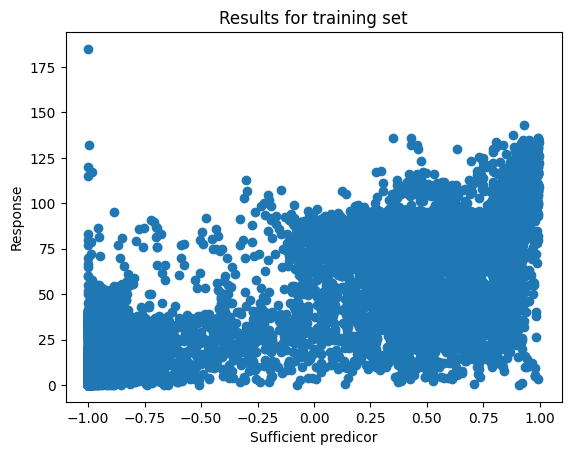

In [7]:
plt.plot(y_suff_train, y_train, 'o', color="C0")
plt.xlabel("Sufficient predicor")
plt.ylabel("Response")
plt.title("Results for training set")
plt.savefig("application-training-StoNet-1.pdf", format="pdf", bbox_inches="tight")
plt.show()

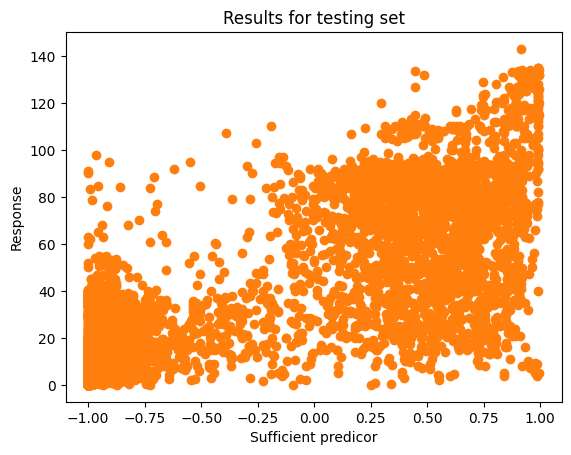

In [8]:
plt.plot(y_suff_test, y_test, 'o', color="C1")
plt.xlabel("Sufficient predicor")
plt.ylabel("Response")
plt.title("Results for testing set")
plt.savefig("application-testing-StoNet-1.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [9]:
y_suff_train_df=pd.DataFrame(y_suff_train)
y_suff_test_df=pd.DataFrame(y_suff_test)
y_suff_train_df.to_csv("./application-results/y_suff_train_StoNet.csv")
y_suff_test_df.to_csv("./application-results/y_suff_test_StoNet.csv")

In [10]:
dcor_res=[dcor.distance_correlation(np.float64(y_suff_train),np.float64(y_train)),
          dcor.distance_correlation(np.float64(y_suff_test),np.float64(y_test))]
dcor_res_df=pd.DataFrame(dcor_res)
dcor_res_df.to_csv("./application-results/dcor_res_StoNet.csv")